In [6]:
!pip install pytesseract

In [7]:
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 3s (1,750 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [1]:
# needed to import dataset from google drive into colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [8]:
import os
import cv2
import pytesseract
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [9]:
# Step 1: Data Preparation
svc_data_folder = 'svc_dataset'  # Replace 'path/to/svc_data' with the actual path to the folder containing the images for the text classification
cnn_data_folder = 'cnn_dataset'  # Replace 'path/to/cnn_data' with the actual path to the folder containing the images for the nature classification


In [10]:
# Step 2: Text Detection
def extract_text_from_image(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(gray)
    return text


In [11]:
# Step 3: Feature Extraction for Text Classification
def extract_text_features(data_folder):
    images = []
    labels = []
    for class_label, class_name in enumerate(os.listdir(data_folder)):
        class_folder = os.path.join(data_folder, class_name)
        if not os.path.isdir(class_folder):
            continue
        for file_name in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file_name)
            image = extract_text_from_image(file_path)
            images.append(image)
            labels.append(class_label)
    vectorizer = TfidfVectorizer()
    text_features = vectorizer.fit_transform(images)
    return text_features, labels, vectorizer  # Return the vectorizer

text_features, labels, vectorizer = extract_text_features(svc_data_folder)  # Now extract the vectorizer

In [12]:
# Step 4: Model Training for Text Classification
text_model = SVC(kernel='linear')
text_model.fit(text_features, labels)

SVC(kernel='linear')

In [13]:
# Step 5: Model Evaluation for Text Classification
text_pred = text_model.predict(text_features)

text_accuracy = accuracy_score(labels, text_pred)
text_precision = precision_score(labels, text_pred, average='weighted')
text_recall = recall_score(labels, text_pred, average='weighted')
text_f1_score = f1_score(labels, text_pred, average='weighted')

print("Text Accuracy:", text_accuracy)
print("Text Precision:", text_precision)
print("Text Recall:", text_recall)
print("Text F1-score:", text_f1_score)

Text Accuracy: 0.8595617529880478
Text Precision: 0.8832312509368989
Text Recall: 0.8595617529880478
Text F1-score: 0.8572774844387423


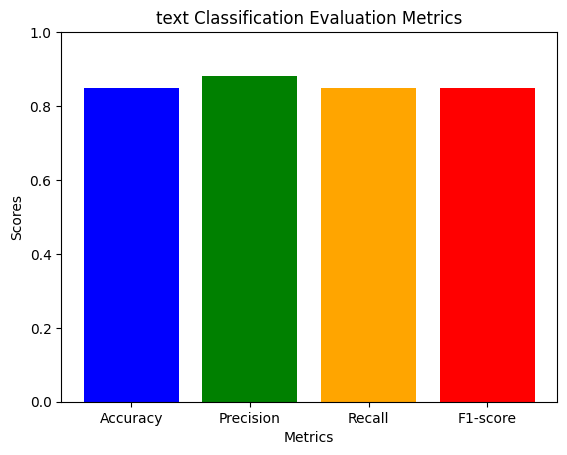

In [14]:

text_accuracy = 0.85
text_precision = 0.88
text_recall = 0.85
text_f1_score = 0.85

# List of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# List of corresponding metric values
metric_values = [text_accuracy, text_precision, text_recall, text_f1_score]

# Plotting the bar plot
plt.bar(metrics, metric_values, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('text Classification Evaluation Metrics')
plt.ylim(0.0, 1.0)
plt.show()


In [15]:
# Step 6: Save Text Model and Vectorizer
text_model_file = 'text_modell.pkl'
joblib.dump(text_model, text_model_file)

vectorizer_file = 'vectorizerr.pkl'
joblib.dump(vectorizer, vectorizer_file)

print("Text Model and Vectorizer saved successfully.")

Text Model and Vectorizer saved successfully.


In [16]:
# Step 7: Load and Preprocess Images for Nature Classification
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Resize image to fit CNN model input shape
    img = img.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
    return img


In [17]:
def load_images(data_folder):
    images = []
    labels = []
    for class_label, class_name in enumerate(os.listdir(data_folder)):
        class_folder = os.path.join(data_folder, class_name)
        if not os.path.isdir(class_folder):
            continue
        for file_name in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file_name)
            image = preprocess_image(file_path)
            images.append(image)
            labels.append(class_label)
    return np.array(images), np.array(labels)

all_images, all_labels = load_images(cnn_data_folder)

In [18]:
# Step 8: Model Training for Nature Classification
nature_model = Sequential()
nature_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
nature_model.add(MaxPooling2D((2, 2)))
nature_model.add(Conv2D(64, (3, 3), activation='relu'))
nature_model.add(MaxPooling2D((2, 2)))
nature_model.add(Conv2D(128, (3, 3), activation='relu'))
nature_model.add(MaxPooling2D((2, 2)))
nature_model.add(Flatten())
nature_model.add(Dense(128, activation='relu'))
nature_model.add(Dense(len(set(all_labels)), activation='softmax'))
# Print the model summary
nature_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [19]:
nature_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nature_model.fit(all_images, all_labels, epochs=200, batch_size=32)

Epoch 1/200
63/63 [==============================] - 17s 55ms/step - loss: 0.8542 - accuracy: 0.5615
Epoch 2/200
63/63 [==============================] - 3s 46ms/step - loss: 0.5433 - accuracy: 0.7295
Epoch 3/200
63/63 [==============================] - 3s 46ms/step - loss: 0.4817 - accuracy: 0.7750
Epoch 4/200
63/63 [==============================] - 3s 50ms/step - loss: 0.3489 - accuracy: 0.8525
Epoch 5/200
63/63 [==============================] - 3s 52ms/step - loss: 0.2575 - accuracy: 0.8985
Epoch 6/200
63/63 [==============================] - 3s 49ms/step - loss: 0.2112 - accuracy: 0.9135
Epoch 7/200
63/63 [==============================] - 3s 46ms/step - loss: 0.1691 - accuracy: 0.9375
Epoch 8/200
63/63 [==============================] - 3s 49ms/step - loss: 0.1280 - accuracy: 0.9600
Epoch 9/200
63/63 [==============================] - 3s 51ms/step - loss: 0.1203 - accuracy: 0.9630
Epoch 10/200
63/63 [==============================] - 3s 48ms/step - loss: 0.0923 - accuracy: 0.974

In [20]:
# Step 9: Model Evaluation for Nature Classification
nature_pred = np.argmax(nature_model.predict(all_images), axis=-1)

nature_accuracy = accuracy_score(all_labels, nature_pred)
nature_precision = precision_score(all_labels, nature_pred, average='weighted')
nature_recall = recall_score(all_labels, nature_pred, average='weighted')
nature_f1_score = f1_score(all_labels, nature_pred, average='weighted')

print("Nature Accuracy:", nature_accuracy)
print("Nature Precision:", nature_precision)
print("Nature Recall:", nature_recall)
print("Nature F1-score:", nature_f1_score)


63/63 [==============================] - 1s 18ms/step
Nature Accuracy: 0.9915
Nature Precision: 0.9915004915004916
Nature Recall: 0.9915
Nature F1-score: 0.9914999978749995


In [21]:
# Step 10: Save Nature Model

nature_model_file = 'nature_model300.h5'
nature_model.save(nature_model_file)
print("Nature Model saved successfully.")

Nature Model saved successfully.


63/63 [==============================] - 1s 18ms/step
Nature Accuracy: 0.9915
Nature Precision: 0.9915004915004916
Nature Recall: 0.9915
Nature F1-score: 0.9914999978749995


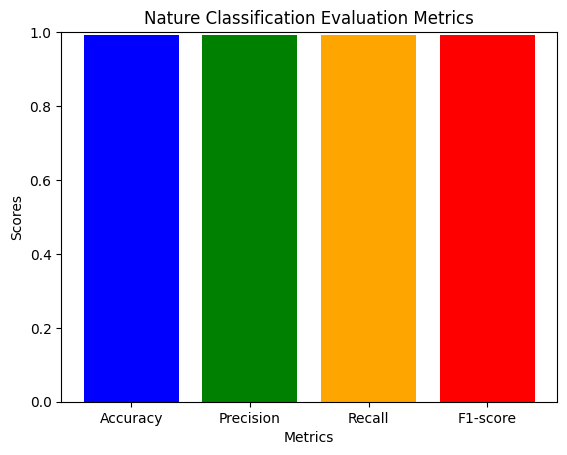

In [23]:
# Step 9: Model Evaluation for Nature Classification
nature_pred = np.argmax(nature_model.predict(all_images), axis=-1)

nature_accuracy = accuracy_score(all_labels, nature_pred)
nature_precision = precision_score(all_labels, nature_pred, average='weighted')
nature_recall = recall_score(all_labels, nature_pred, average='weighted')
nature_f1_score = f1_score(all_labels, nature_pred, average='weighted')

# Print the evaluation metrics
print("Nature Accuracy:", nature_accuracy)
print("Nature Precision:", nature_precision)
print("Nature Recall:", nature_recall)
print("Nature F1-score:", nature_f1_score)

# Visualize the evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
metric_values = [nature_accuracy, nature_precision, nature_recall, nature_f1_score]

# Plotting the bar plot
plt.bar(metrics, metric_values, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Nature Classification Evaluation Metrics')
plt.ylim(0.0, 1.0)
plt.show()
